# RSA Example with MNE Sample Data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from eelbrain import *

Import distance and correlation functions
- `pdist` takes a list of vectors and computes pairwise distances
- `squareform` alternates between triangle and full matrix

In [2]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

Load MNE sample data

In [3]:
ds = datasets.get_mne_sample(src='ico', sub=range(100))
ds = ds.sub("modality.isin(['A', 'V'])")
ds.head()

trigger   i_start   index   condition   side   modality
-------------------------------------------------------
2         6994      0       RA          R      A       
3         7086      1       LV          L      V       
1         7192      2       LA          L      A       
4         7304      3       RV          R      V       
2         7413      4       RA          R      A       
3         7506      5       LV          L      V       
1         7612      6       LA          L      A       
4         7709      7       RV          R      V       
2         7810      8       RA          R      A       
3         7916      9       LV          L      V       

Code condition (L/R, A/V) combinations as numeric placeholders

In [4]:
variable = ds['condition']
model = variable.as_labels()
label_map = {'LA': 1, 'RA': 2, 'LV': 3, 'RV': 4}
model = map(lambda x: label_map[x], model)
model = np.array(model)
model = model.reshape(-1, 1)
print model[:10]

[[2]
 [3]
 [1]
 [4]
 [2]
 [3]
 [1]
 [4]
 [2]
 [3]]


Make model RDM: similar if same condition, else dissimilar

In [5]:
model_rdm = pdist(model, lambda x, y: 0 if x==y else 1)
print model_rdm
print model_rdm.shape

[ 1.  1.  1. ...,  1.  1.  1.]
(4095,)


Visualize model RDM

/Users/linglab/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


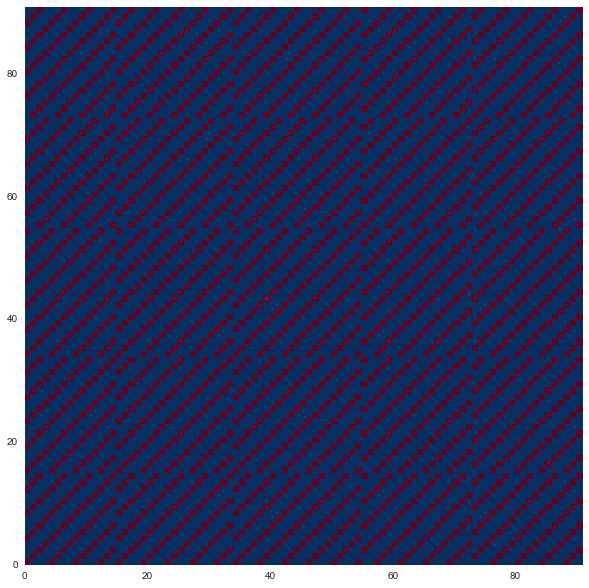

In [6]:
model_rdm_sq = squareform(model_rdm)
plt.figure(figsize=(10, 10))
plt.pcolor(model_rdm_sq, cmap="RdBu")
plt.xlim(0, ds.n_cases)
plt.ylim(0, ds.n_cases)
plt.show()

Get data from 3 ROIs

In [7]:
src = ds['src']
data = {}
data['STG'] = src.sub(source='superiortemporal-lh').x
data['IFG'] = src.sub(source='parsopercularis-lh').x
data['Occ'] = src.sub(source='lateraloccipital-lh').x

N = ds.n_cases # number of items
N_times = src.time.times.shape[0] # number of timepoints
for i, j in data.items():
    print i, j.shape

Occ (91, 88, 76)
STG (91, 98, 76)
IFG (91, 50, 76)


In [8]:
rhos = {'STG': [], 'IFG': [], 'Occ': []}

In [9]:
for region, d in data.items():
    for i in range(N_times)[4:-4]:
        # get all sources and +/- 4 time points
        data_window = d[:,:,i-4:i+5]
        # flatten
        data_window = data_window.reshape(N, -1)
        # make data RDM
        data_rdm = pdist(data_window, 'correlation')
        # calculate model-data correspondence
        rho = spearmanr(model_rdm, data_rdm)[0]
        rhos[region].append(rho)

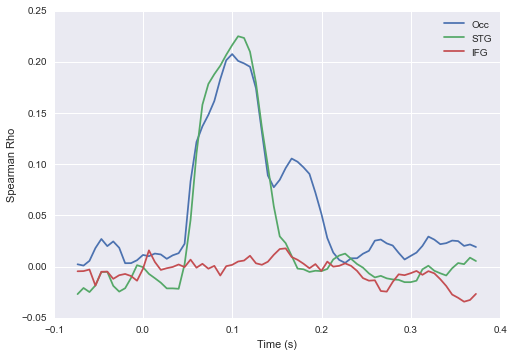

In [10]:
for region, corrs in rhos.items():
    plt.plot(src.time.times[4:-4], corrs, label=region)
plt.legend()
plt.ylabel("Spearman Rho")
plt.xlabel("Time (s)")
sns.despine()